# Принцип работы модели ARIMA с использованием автоматизированного подбора параметров

## 1.1 Подбор порядка интегрирования `d`

На первом этапе для модели ARIMA осуществляется автоматизированный подбор порядка интегрирования `d`, необходимого для приведения временного ряда к стационарному виду. Процедура реализуется встроенными методами функции `auto_arima`, которая, при необходимости, проводит тесты на стационарность (например, ADF-тест или KPSS-тест) и последовательно увеличивает значение `d`, пока ряд {∆^d y_t} не станет стационарным. Однако в данном случае порядок интегрирования был задан вручную (`d = 1`), и автоматическая проверка стационарности отключена.

## 1.2 Подбор порядков `p` и `q`

Следующим этапом выполняется автоматизированный подбор порядка авторегрессионной компоненты `p` и порядка скользящего среднего `q`. Для этого функция `auto_arima` строит множество моделей ARIMA(p, d, q) в пределах заданного диапазона значений p и q (от 0 до 3) и использует пошаговый (stepwise) алгоритм оптимизации. Каждая модель оценивается методом максимального правдоподобия (MLE), а качество моделей сравнивается с помощью информационных критериев AIC (Akaike Information Criterion) и BIC (Bayesian Information Criterion). Выбирается модель с наименьшим значением AIC, что позволяет достичь оптимального баланса между точностью прогноза и сложностью модели.

Таким образом, использование функции `auto_arima` значительно упрощает процесс построения модели ARIMA, обеспечивая автоматический выбор параметров при сохранении высокой прогностической способности модели.

# Основные используемые библиотеки

- **pmdarima** — библиотека для автоматизированного подбора моделей ARIMA и SARIMA. Включает функции `auto_arima`, обеспечивающие подбор порядка интегрирования, авторегрессии и скользящего среднего на основе критериев AIC/BIC.
- **pandas** — библиотека для обработки и анализа табличных данных. Используется для загрузки, фильтрации и подготовки временных рядов.
- **numpy** — библиотека для работы с числовыми массивами и вычисления статистических метрик.
- **scikit-learn** — библиотека машинного обучения, используется для расчета метрик качества прогноза (MAE, RMSE, MAPE).
- **matplotlib** — библиотека для визуализации данных. Применяется для построения графиков фактических и прогнозных значений временного ряда.
- **warnings** — стандартный модуль Python для подавления предупреждений при выполнении кода.


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1981.483, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2016.903, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1988.645, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1982.335, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2015.101, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1979.574, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1978.349, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1979.261, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1977.580, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1979.574, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1981.078, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1975.739, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1980.476, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1986.785, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]          

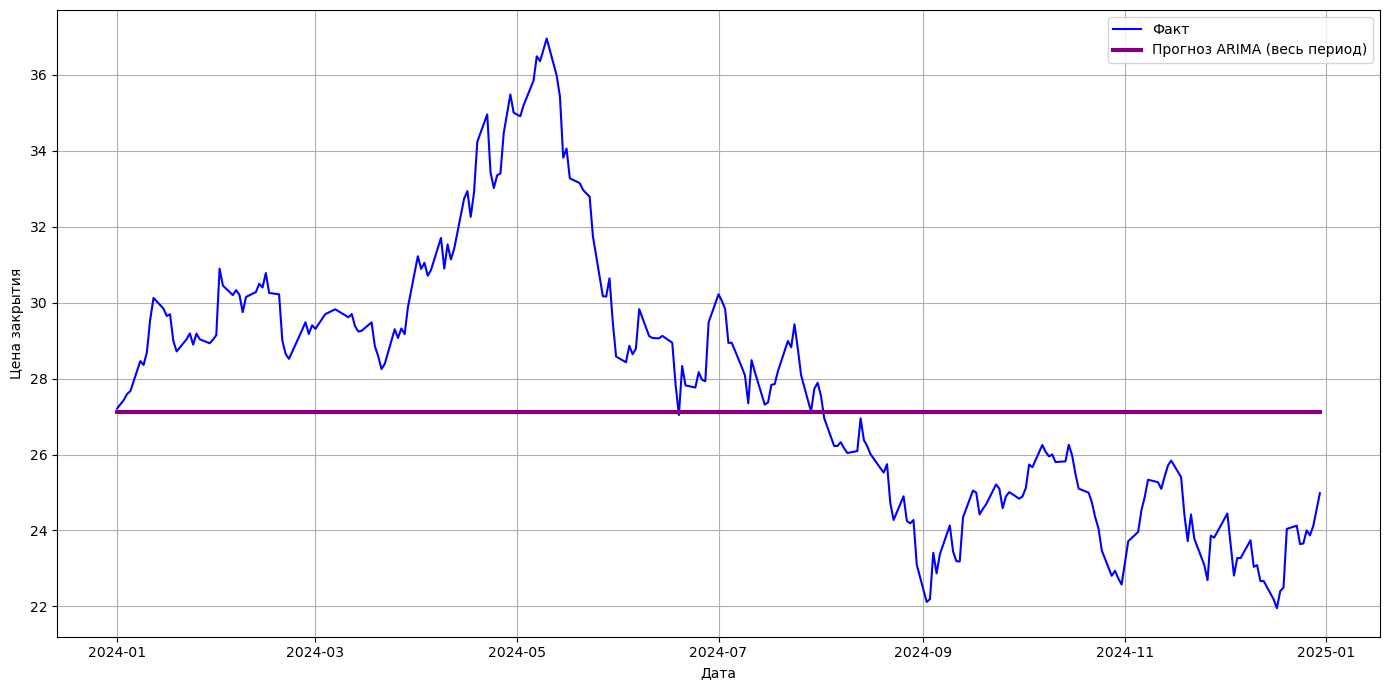

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Загрузка и предобработка
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sngs_merged_data_old.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df[["Stock Close"]].interpolate().ffill().dropna()

# Разделение
split_idx = int(len(df) * 0.75)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]

# Обучение ARIMA
y_train, y_test = train['Stock Close'], test['Stock Close']

# Автоматический подбор модели
model_arima = auto_arima(y_train, seasonal=False, d=1, trace=True,
                         stepwise=True, suppress_warnings=True, max_p=3, max_q=3)

print("Выбран порядок ARIMA:", model_arima.order)

# Прогноз на всю тестовую выборку
forecast_arima = model_arima.predict(n_periods=len(y_test))

# Метрики для всего периода
mae_total = mean_absolute_error(y_test, forecast_arima)
rmse_total = np.sqrt(mean_squared_error(y_test, forecast_arima))
mape_total = np.mean(np.abs((y_test - forecast_arima) / y_test)) * 100
print(f"Метрики для всего периода - MAE: {mae_total:.3f}, RMSE: {rmse_total:.3f}, MAPE: {mape_total:.2f}%")

# Прогноз на первые 7 дней
forecast_7 = forecast_arima[:7]
dates_7 = y_test.index[:7]
y_test_7 = y_test.loc[dates_7]

# Метрики для первых 7 дней
mae_7 = mean_absolute_error(y_test_7, forecast_7)
rmse_7 = np.sqrt(mean_squared_error(y_test_7, forecast_7))
mape_7 = np.mean(np.abs((y_test_7 - forecast_7) / y_test_7)) * 100
print(f"Метрики для первых 7 дней - MAE: {mae_7:.3f}, RMSE: {rmse_7:.3f}, MAPE: {mape_7:.2f}%")

# --- ПЕРВЫЙ график: весь тестовый период ---
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Факт', color='blue')
plt.plot(y_test.index, forecast_arima, label='Прогноз ARIMA (весь период)', color="purple", linewidth=3)
#plt.title('Прогноз ARIMA на весь тестовый период')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

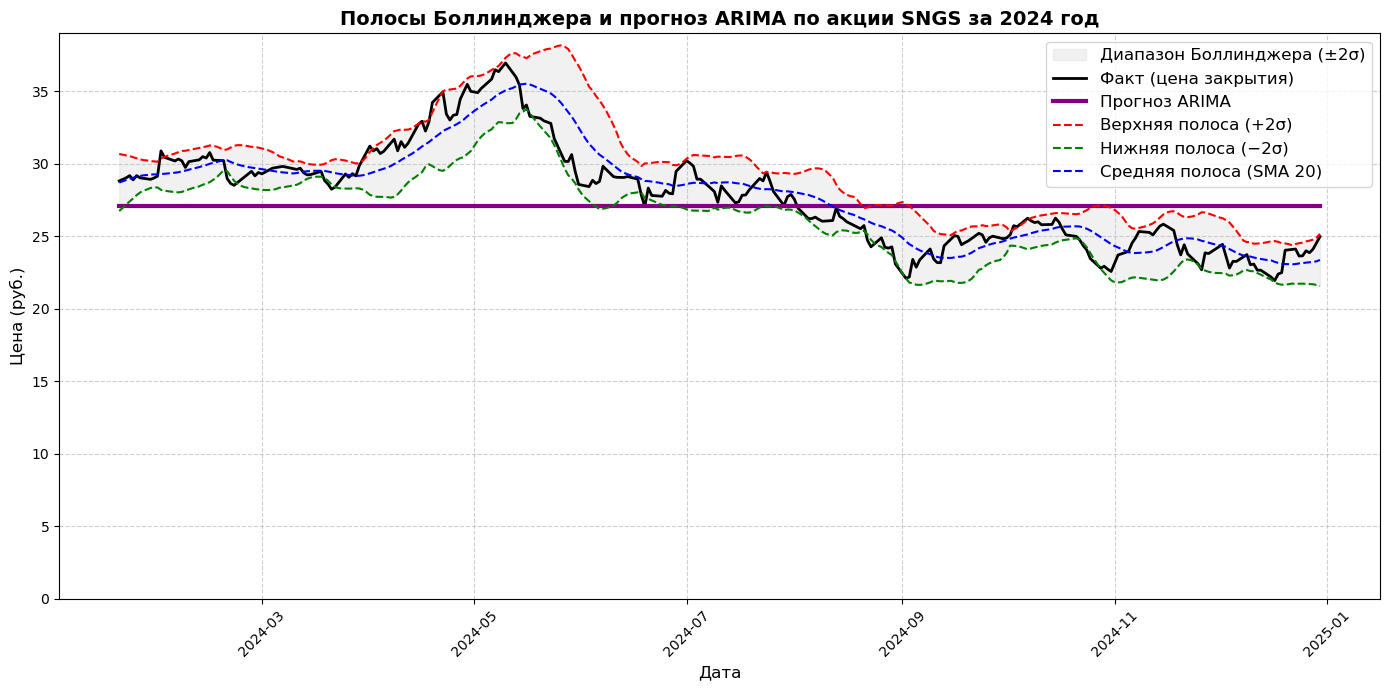

In [3]:
# === Полосы Боллинджера и прогноз ARIMA на фоне ===

# Подготовка данных за 2024 год
df_boll = df.loc["2024-01-01":"2024-12-31"].copy()
df_boll["close"] = df_boll["Stock Close"]

# Расчёт полос Боллинджера:
# - Средняя полоса: скользящее среднее по 20 дням
# - Верхняя полоса: средняя + 2 стандартных отклонения
# - Нижняя полоса: средняя - 2 стандартных отклонения
df_boll["bollinger_mid"] = df_boll["close"].rolling(window=20).mean()
df_boll["bollinger_std"] = df_boll["close"].rolling(window=20).std()
df_boll["bollinger_upper"] = df_boll["bollinger_mid"] + 2 * df_boll["bollinger_std"]
df_boll["bollinger_lower"] = df_boll["bollinger_mid"] - 2 * df_boll["bollinger_std"]
df_boll.dropna(subset=["bollinger_upper", "bollinger_lower"], inplace=True)

# Получение прогноза ARIMA в пределах 2024 года
forecast_overlay = pd.Series(forecast_arima, index=y_test.index)
forecast_for_boll = forecast_overlay.loc[df_boll.index.intersection(forecast_overlay.index)]

# Данные для визуализации
actual_for_boll = df_boll["close"].loc[forecast_for_boll.index]
upper = df_boll["bollinger_upper"].loc[forecast_for_boll.index]
lower = df_boll["bollinger_lower"].loc[forecast_for_boll.index]
mid = df_boll["bollinger_mid"].loc[forecast_for_boll.index]

# === Построение графика ===
plt.figure(figsize=(14, 7))

# Заливка между верхней и нижней полосами Боллинджера
plt.fill_between(df_boll.index, df_boll["bollinger_lower"], df_boll["bollinger_upper"], 
                 color="lightgray", alpha=0.3, label="Диапазон Боллинджера (±2σ)")

# Фактическая цена — жирной чёрной линией
plt.plot(actual_for_boll.index, actual_for_boll, label="Факт (цена закрытия)", color="black", linewidth=2)

# Прогноз ARIMA — фиолетовая линия
plt.plot(forecast_for_boll.index, forecast_for_boll, label="Прогноз ARIMA", color="purple", linewidth=3)

# Верхняя и нижняя полосы — пунктиром
plt.plot(upper.index, upper, label="Верхняя полоса (+2σ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(lower.index, lower, label="Нижняя полоса (−2σ)", color="green", linestyle="--", linewidth=1.5)

# Средняя полоса Боллинджера (σ = 0) — синяя пунктирная линия
plt.plot(mid.index, mid, label="Средняя полоса (SMA 20)", color="blue", linestyle="--", linewidth=1.5)

# Оформление
plt.title("Полосы Боллинджера и прогноз ARIMA по акции SNGS за 2024 год", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена (руб.)", fontsize=12)
plt.ylim(bottom=0)  # ← ВОТ ЭТА СТРОКА — ось Y начинается с 0
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🎯 Описание графика: Полосы Боллинджера и прогноз ARIMA по акции SNGS за 2024 год
На графике представлены ключевые элементы анализа временного ряда с использованием полос Боллинджера и модели ARIMA:

 - Черная жирная линия — Фактическая цена закрытия (Stock Close)
Отображает реальную динамику цены акции SNGS за 2024 год. Используется как основа для расчёта всех индикаторов и сравнения с модельным прогнозом.

 - Синяя пунктирная линия — Средняя полоса (SMA 20)
Скользящее среднее за 20 дней:
SMA(t) = среднее значение цены закрытия за последние 20 торговых дней.
Задаёт центральную тенденцию и служит базой для расчёта границ ±2σ.

 - Красная пунктирная линия — Верхняя полоса (+2σ)
Вычисляется по формуле:
Upper(t) = SMA(t) + 2 × σ(t),
где σ(t) — стандартное отклонение цены за последние 20 дней.
Указывает на потенциальные уровни перекупленности.

 - Зелёная пунктирная линия — Нижняя полоса (−2σ)
Вычисляется как:
Lower(t) = SMA(t) − 2 × σ(t).
Может свидетельствовать о перепроданности и коррекциях вниз.

 - Фиолетовая пунктирная линия — Прогноз ARIMA
Отражает прогноз цены, полученный с помощью модели ARIMA, построенной на данных до 2024 года.
Сравнение прогноза с фактом и полосами позволяет визуально оценить точность модели и рыночную реакцию.

 - Серый залитый диапазон между верхней и нижней полосами
Иллюстрирует область волатильности в рамках ±2 стандартных отклонений.
Ширина заливки соответствует степени нестабильности на рынке.



## Тест Грейнджера и построение модели ARIMAX
На первом этапе построения модели ARIMAX был проведён предварительный статистический отбор значимых экзогенных переменных с использованием теста Грейнджера. Данный тест позволяет определить, оказывает ли прошлая динамика внешней переменной (экзогенного фактора) влияние на текущие значения целевой переменной. В процессе проведения теста Грейнджера проверяется наличие причинно-следственной связи между рядом экзогенных факторов и ценой закрытия акций.

Для каждой пары "целевая переменная — экзогенная переменная" тест Грейнджера проводился на различных лагах в пределах установленного максимального значения. На каждом лаге рассчитывалось значение p-value, отражающее вероятность отсутствия причинной связи. Оптимальный лаг для каждой переменной определялся как тот, на котором значение p-value было минимальным, что указывало на максимальное статистическое влияние экзогенного фактора на целевую переменную. Таким образом, оптимальное значение лага выявляется непосредственно в ходе проведения теста Грейнджера и используется в последующем моделировании.

На основании результатов тестирования была сформирована выборка экзогенных переменных для модели ARIMAX. При построении модели был использован метод автоматического подбора порядков авторегрессии (p) и скользящего среднего (q) на основе минимизации информационного критерия Акаике (AIC). Модель строилась без лагирования экзогенных переменных, подразумевая их известность на момент прогнозирования.

Для проверки качества модели был проведён анализ остатков, включающий тесты на отсутствие автокорреляции и проверку нормальности распределения ошибок. Основные метрики качества прогнозирования, такие как средняя абсолютная ошибка (MAE) и среднеквадратичная ошибка (RMSE), подтвердили удовлетворительный уровень точности краткосрочного прогноза. Дополнительно был построен долгосрочный прогноз на два года вперёд, результаты которого продемонстрировали устойчивость и релевантность выбранных экзогенных факторов при условии наличия достоверной информации о будущем поведении этих переменных.

Таким образом, использование теста Грейнджера на этапе предварительного отбора экзогенных переменных позволило значительно повысить обоснованность структуры модели ARIMAX и обеспечить её прогностическую эффективность.

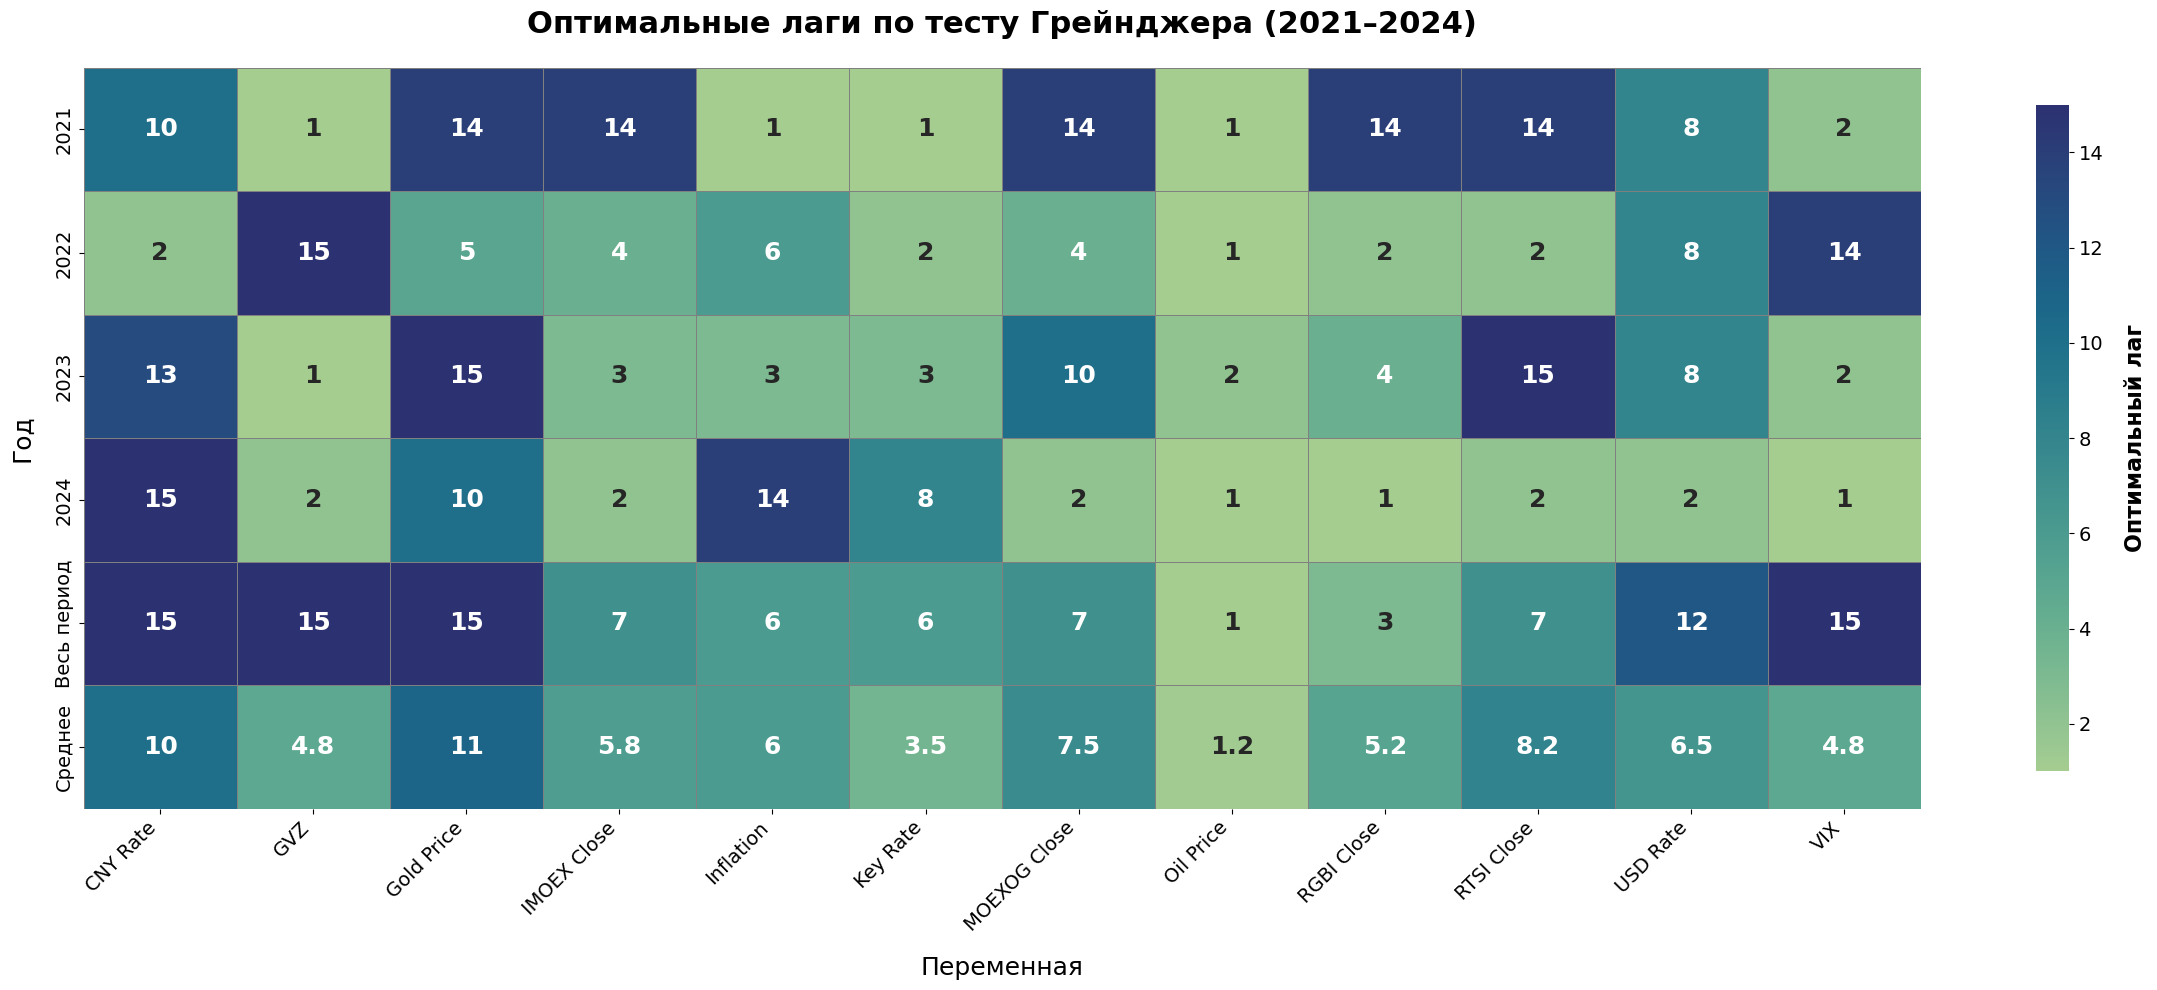

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import grangercausalitytests

warnings.filterwarnings("ignore")

# === 1. Загрузка полного набора данных ===
merged_data = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sngs_merged_data_old.csv", parse_dates=["Date"])
merged_data.set_index("Date", inplace=True)

# Ограничим период 2021-2024
merged_data = merged_data.loc["2021-01-01":"2024-12-31"]

# Заполняем пропуски, если есть
merged_data = merged_data.interpolate().ffill().dropna()

# === 2. Для ARIMA (только Stock Close) ===
df = merged_data[["Stock Close"]]

# Разделение на train/test
split_idx = int(len(df) * 0.75)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]

# === 3. Тест Грейнджера ===

# Список годов
years = range(2021, 2025)  # С 2021 по 2024 включительно

# Переменные, кроме 'Stock Close'
excluded_cols = ["Stock Close"]
variables = [col for col in merged_data.columns if col not in excluded_cols]

# Максимальный лаг
max_lag = 15

# Словарь для хранения оптимальных лагов
granger_lags = {}

for year in years:
    df_year = merged_data[merged_data.index.year == year]
    result_row = {}

    for var in variables:
        try:
            test_data = df_year[["Stock Close", var]].dropna()
            if test_data.shape[0] > max_lag:
                test_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
                p_values = {lag: test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)}
                best_lag = min(p_values, key=p_values.get)
                result_row[var] = best_lag
            else:
                result_row[var] = None
        except Exception:
            result_row[var] = None

    granger_lags[str(year)] = result_row

# Формируем итоговую таблицу лагов
granger_lags_df = pd.DataFrame(granger_lags).T
granger_lags_df = granger_lags_df[sorted(granger_lags_df.columns)]

# === 4. Добавляем строку "Весь период" ===
all_period_row = {}
for var in variables:
    try:
        test_data = merged_data[["Stock Close", var]].dropna()
        if test_data.shape[0] > max_lag:
            test_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
            p_values = {lag: test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)}
            best_lag = min(p_values, key=p_values.get)
            all_period_row[var] = best_lag
        else:
            all_period_row[var] = None
    except Exception:
        all_period_row[var] = None

granger_lags_df.loc["Весь период"] = pd.Series(all_period_row)

# === 5. Добавляем строку "Среднее" ===
years_only = [str(y) for y in years if str(y) in granger_lags_df.index]
granger_lags_df.loc["Среднее"] = granger_lags_df.loc[years_only].mean(numeric_only=True).round(1)

# === 6. Визуализация тепловой карты оптимальных лагов (без транспонирования) ===
plt.figure(figsize=(24, 10))  # ширина для переменных, высота умеренная

heatmap = sns.heatmap(
    granger_lags_df,  # без .T — сохраняем структуру: годы по Y, переменные по X
    annot=True,
    fmt="g",
    cmap="crest",
    linewidths=0.6,
    linecolor="gray",
    annot_kws={"size": 18, "weight": "bold"},
    cbar_kws={
        "label": "Оптимальный лаг",
        "shrink": 0.9
    }
)

# Заголовок и подписи
plt.title("Оптимальные лаги по тесту Грейнджера (2021–2024)", fontsize=22, fontweight="bold", pad=25)
plt.xlabel("Переменная", fontsize=18, labelpad=15)
plt.ylabel("Год", fontsize=18, labelpad=15)

# Размер шрифта на осях
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)

# Оформление легенды
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label("Оптимальный лаг", fontsize=16, weight="bold", labelpad=15)

plt.tight_layout()
plt.show()



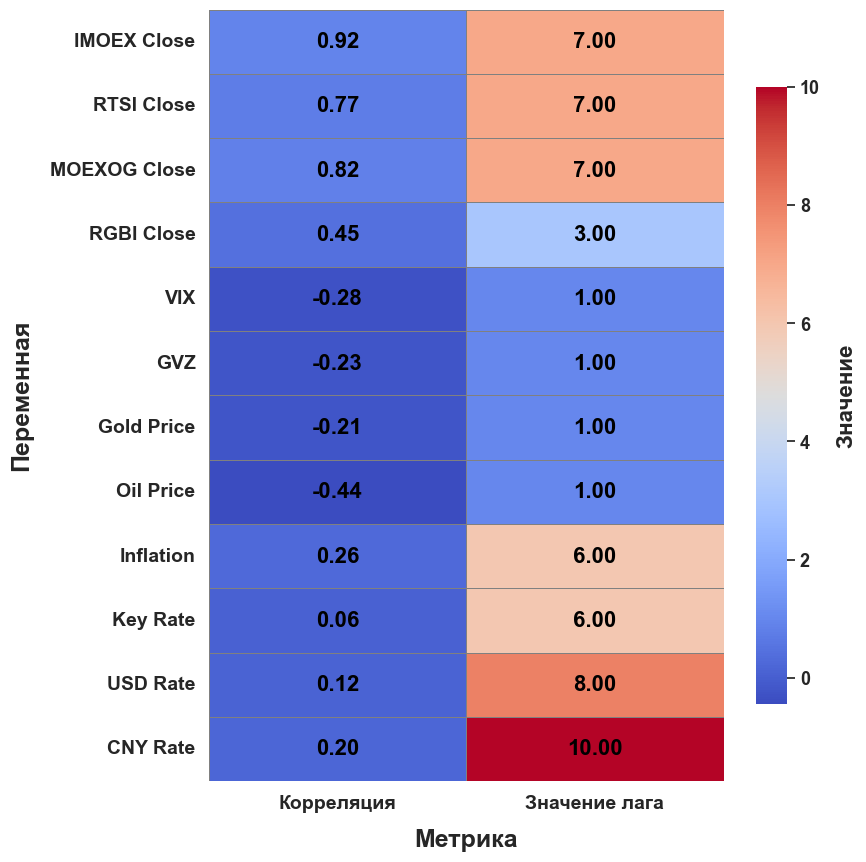

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

# === Загрузка и подготовка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sngs_merged_data_old.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]

# Целевая переменная и признаки
target = 'Stock Close'
best_features = [col for col in df.columns if col != target]

# Интерполяция и очистка
df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === Расчёт корреляций ===
years = [2021, 2022, 2023, 2024]
corr_by_year = {}
for year in years:
    corr = df[df.index.year == year].corr()
    corr_by_year[str(year)] = corr[target].drop(target)

# Общая корреляция
corr_total = df.corr()
corr_by_year["Весь период"] = corr_total[target].drop(target)
corr_by_year_df = pd.DataFrame(corr_by_year)

# === Оптимальные лаги Грейнджера ===
lags_total = {}
for feature in best_features:
    try:
        test_result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [test_result[i + 1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        lags_total[feature] = optimal_lag
    except Exception:
        lags_total[feature] = np.nan

# === Итоговая таблица ===
lags_total_series = pd.Series(lags_total, name="Оптимальный лаг")
corr_total_series = corr_by_year_df["Весь период"]
arimax_total_selection = pd.concat([corr_total_series, lags_total_series], axis=1)
arimax_total_selection.columns = ["Корреляция", "Значение лага"]

# === Визуализация ===
plt.figure(figsize=(9, 9))  # Уменьшен размер графика для компактных ячеек
sns.set_style("white")

heatmap = sns.heatmap(
    arimax_total_selection,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.6,
    linecolor="gray",
    annot_kws={"size": 16, "weight": "bold", "color": "black"},  # Жирный и крупный шрифт в ячейках
    cbar_kws={"label": "Значение", "shrink": 0.8}
)

# Подписи осей
plt.xlabel("Метрика", fontsize=18, fontweight="bold", labelpad=12)
plt.ylabel("Переменная", fontsize=18, fontweight="bold", labelpad=12)

# Настройка шрифтов осей
plt.xticks(fontsize=14, fontweight="bold", rotation=0)
plt.yticks(fontsize=14, fontweight="bold", rotation=0)

# Цветовая шкала
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=13)
colorbar.set_label("Значение", fontsize=16, fontweight="bold", labelpad=12)

plt.tight_layout()
plt.show()


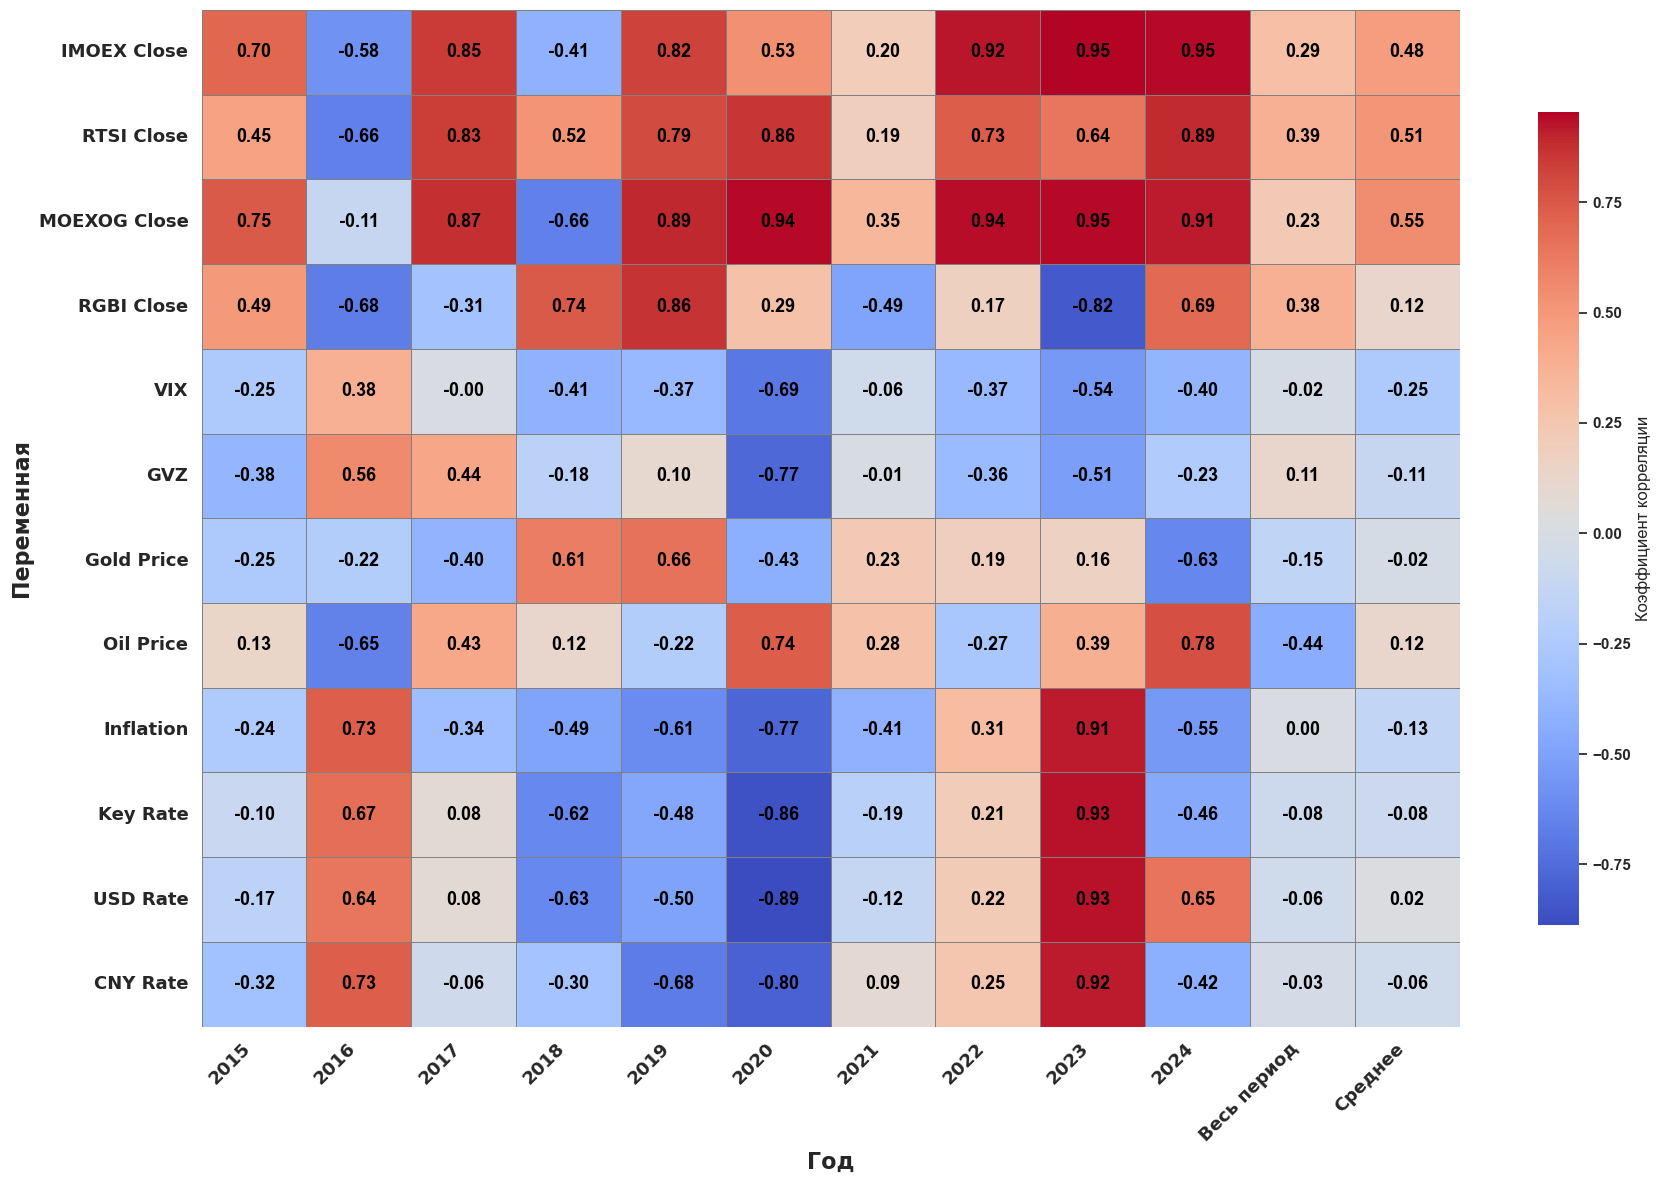

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")

# Настройки шрифта и стиля
plt.rcParams['font.family'] = 'DejaVu Sans'  # Можно заменить на Arial или другой
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

# === Загрузка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sngs_merged_data_old.csv", parse_dates=["Date"], index_col="Date").asfreq("D")
df = df.loc["2015-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]

# Целевая переменная и экзогенные
target = "Stock Close"
exog_vars = [col for col in df.columns if col != target]

# Предобработка
df[exog_vars] = df[exog_vars].interpolate().ffill()
df = df.dropna()

# === Расчёт корреляций по годам ===
years = list(range(2015, 2025))
corr_by_year = {}

for year in years:
    df_year = df[df.index.year == year]
    corr = df_year.corr()
    corr_by_year[str(year)] = corr[target].drop(target)

# Корреляция за весь период
corr_by_year["Весь период"] = df.corr()[target].drop(target)

# Таблица корреляций
corr_by_year_df = pd.DataFrame(corr_by_year)
corr_by_year_df["Среднее"] = corr_by_year_df.mean(axis=1)

# === Построение тепловой карты ===
fig, ax = plt.subplots(figsize=(18, 12))
sns.set(style="white")

heatmap = sns.heatmap(
    corr_by_year_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    annot_kws={
        "size": 13,
        "weight": "bold",
        "color": "black"
    },
    cbar_kws={
        "label": "Коэффициент корреляции",
        "shrink": 0.8
    },
    ax=ax
)

# Настройка подписей и внешнего вида
#ax.set_title("Годовая корреляция экзогенных переменных с ценой акции", fontsize=22, fontweight="bold", pad=25)
ax.set_xlabel("Год", fontsize=16, fontweight="bold")
ax.set_ylabel("Переменная", fontsize=16, fontweight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=13, fontweight="bold")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1981.483, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2016.903, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1988.645, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1982.335, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2015.101, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1979.574, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1978.349, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1979.261, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1977.580, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1979.574, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1981.078, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1975.739, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1980.476, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1986.785, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]          

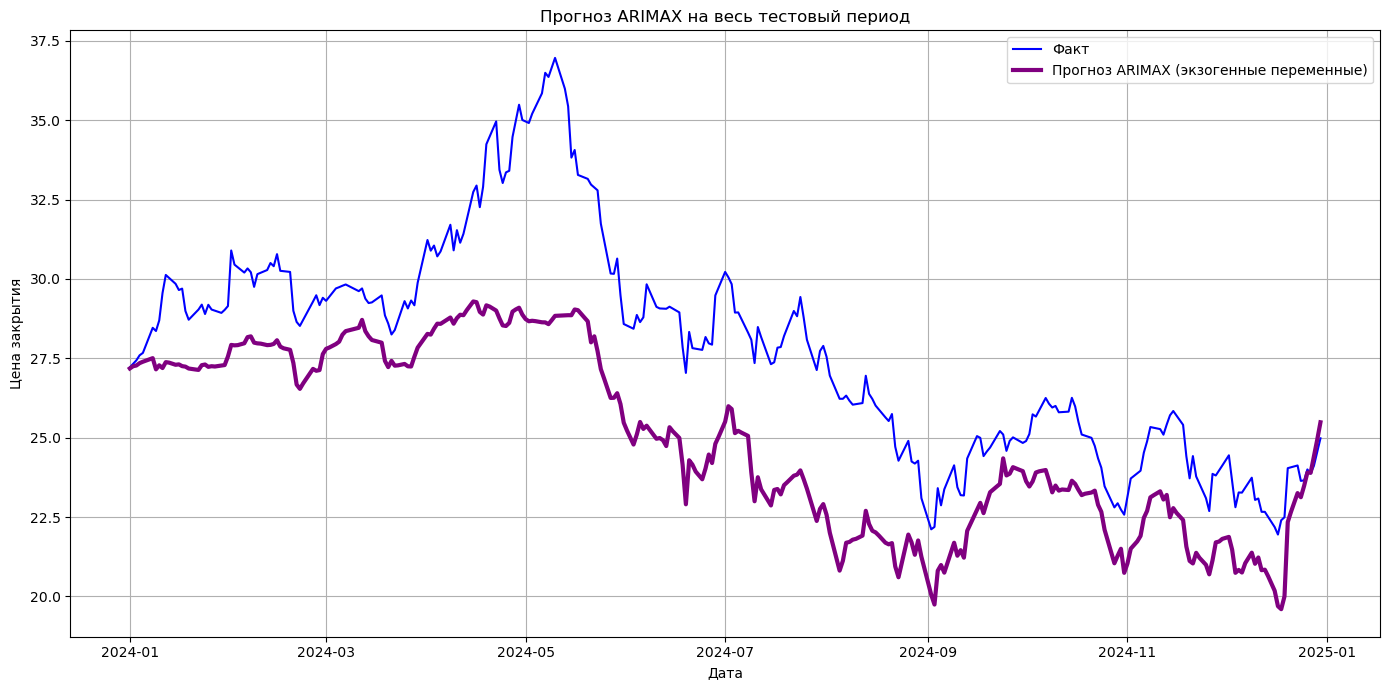

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

# === Загрузка и подготовка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sngs_merged_data_old.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]  # удалим константы

# === Выбор экзогенных переменных ===

# Использовать жёстко заданный список:
#best_features = ["IMOEX Close", "MOEXOG Close", "RGBI Close", "Oil Price"]

# Либо — использовать все столбцы, кроме 'Stock Close':
best_features = [col for col in df.columns if col != 'Stock Close']

# Проверка наличия всех переменных в датафрейме
best_features = [f for f in best_features if f in df.columns]

# === Интерполяция и нормализация экзогенов ===
df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

scaler = MinMaxScaler()
df[best_features] = scaler.fit_transform(df[best_features])

# === Сплит данных ===
split_idx = int(len(df) * 0.75)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]
y_train, X_train = train['Stock Close'], train[best_features]
y_test, X_test = test['Stock Close'], test[best_features]

# === Обучение ARIMAX ===
optimal_arima = auto_arima(y_train, exogenous=X_train, seasonal=False, d=1, trace=True,
                           stepwise=True, suppress_warnings=True, max_p=3, max_q=3)
print(f"Выбран порядок ARIMA: {optimal_arima.order}")

model = SARIMAX(y_train, exog=X_train, order=optimal_arima.order)
model_fit = model.fit(maxiter=1000, method='powell')

# === Прогноз ===
forecast_arimax = model_fit.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test).fillna(method='ffill')
forecast_arimax_no_lags = forecast_arimax  # сохраняем для сравнения с другими моделями

# === Метрики для всего тестового периода ===
mae = mean_absolute_error(y_test, forecast_arimax)
rmse = np.sqrt(mean_squared_error(y_test, forecast_arimax))
mape = np.mean(np.abs((y_test - forecast_arimax) / y_test)) * 100
print(f"Метрики для всего периода - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%")

# === Метрики для первых 7 дней ===
forecast_7 = forecast_arimax[:7]
dates_7 = y_test.index[:7]
y_test_7 = y_test.loc[dates_7]

mae_7 = mean_absolute_error(y_test_7, forecast_7)
rmse_7 = np.sqrt(mean_squared_error(y_test_7, forecast_7))
mape_7 = np.mean(np.abs((y_test_7 - forecast_7) / y_test_7)) * 100
print(f"Метрики для первых 7 дней - MAE: {mae_7:.3f}, RMSE: {rmse_7:.3f}, MAPE: {mape_7:.2f}%")

# === График 1: весь тестовый период ===
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Факт', color='blue')
plt.plot(y_test.index, forecast_arimax, label='Прогноз ARIMAX (экзогенные переменные)', color="purple", linewidth=3)
plt.title('Прогноз ARIMAX на весь тестовый период')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

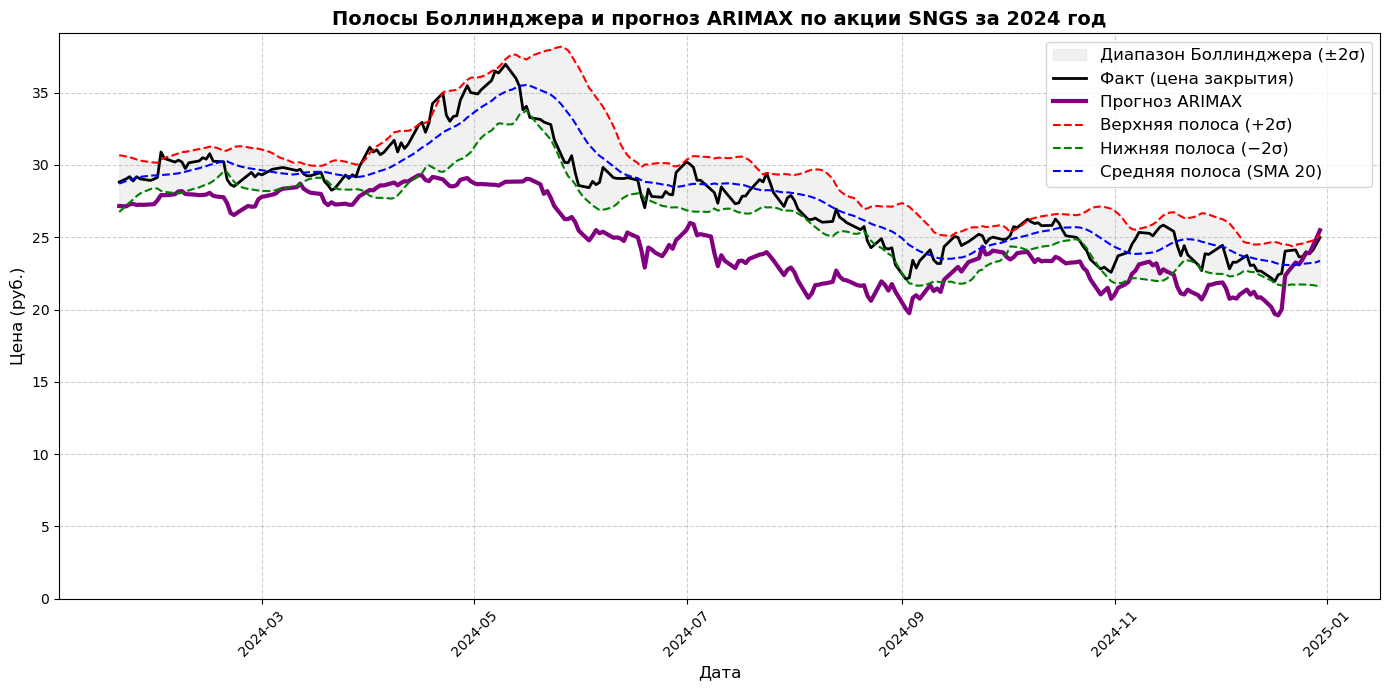

In [9]:
# === Полосы Боллинджера и прогноз ARIMAX по акции SNGS за 2024 год ===

# Подготовка данных за 2024 год
df_boll = df.loc["2024-01-01":"2024-12-31"].copy()
df_boll["close"] = df_boll["Stock Close"]

# Расчёт полос Боллинджера:
# - Средняя полоса: скользящее среднее по 20 дням
# - Верхняя полоса: средняя + 2 стандартных отклонения
# - Нижняя полоса: средняя - 2 стандартных отклонения
df_boll["bollinger_mid"] = df_boll["close"].rolling(window=20).mean()
df_boll["bollinger_std"] = df_boll["close"].rolling(window=20).std()
df_boll["bollinger_upper"] = df_boll["bollinger_mid"] + 2 * df_boll["bollinger_std"]
df_boll["bollinger_lower"] = df_boll["bollinger_mid"] - 2 * df_boll["bollinger_std"]
df_boll.dropna(subset=["bollinger_upper", "bollinger_lower"], inplace=True)

# Получение прогноза ARIMAX в пределах 2024 года
forecast_overlay = pd.Series(forecast_arimax, index=y_test.index)
forecast_for_boll = forecast_overlay.loc[df_boll.index.intersection(forecast_overlay.index)]

# Данные для визуализации
actual_for_boll = df_boll["close"].loc[forecast_for_boll.index]
upper = df_boll["bollinger_upper"].loc[forecast_for_boll.index]
lower = df_boll["bollinger_lower"].loc[forecast_for_boll.index]
mid = df_boll["bollinger_mid"].loc[forecast_for_boll.index]

# === Построение графика ===
plt.figure(figsize=(14, 7))

# Заливка между верхней и нижней полосами Боллинджера
plt.fill_between(df_boll.index, df_boll["bollinger_lower"], df_boll["bollinger_upper"], 
                 color="lightgray", alpha=0.3, label="Диапазон Боллинджера (±2σ)")

# Фактическая цена — жирной чёрной линией
plt.plot(actual_for_boll.index, actual_for_boll, label="Факт (цена закрытия)", color="black", linewidth=2)

# Прогноз ARIMAX — фиолетовая пунктирная линия
plt.plot(forecast_for_boll.index, forecast_for_boll, label="Прогноз ARIMAX", color="purple", linewidth=3)

# Верхняя и нижняя полосы — пунктиром
plt.plot(upper.index, upper, label="Верхняя полоса (+2σ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(lower.index, lower, label="Нижняя полоса (−2σ)", color="green", linestyle="--", linewidth=1.5)

# Средняя полоса Боллинджера (σ = 0) — синяя пунктирная линия
plt.plot(mid.index, mid, label="Средняя полоса (SMA 20)", color="blue", linestyle="--", linewidth=1.5)

# Оформление
plt.title("Полосы Боллинджера и прогноз ARIMAX по акции SNGS за 2024 год", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена (руб.)", fontsize=12)
plt.ylim(bottom=0)  # ← ВОТ ЭТА СТРОКА — ось Y начинается с 0
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📊 Полосы Боллинджера и прогноз ARIMAX по акции SNGS (2024)
График объединяет элементы технического и статистического анализа, позволяя оценить волатильность рынка и качество прогноза модели ARIMAX.

 - Чёрная линия — фактическая цена закрытия акции (Stock Close) за 2024 год. Используется как основа для расчёта скользящей средней и оценки точности прогноза.

 - Синяя пунктирная линия — средняя полоса (SMA 20), рассчитанная как среднее значение цен закрытия за 20 торговых дней:

SMA(t) = (Pₜ + Pₜ₋₁ + … + Pₜ₋₁₉) / 20

 - Красная и зелёная пунктирные линии — границы полос Боллинджера:

Upper(t) = SMA(t) + 2σ(t)
Lower(t) = SMA(t) − 2σ(t)
где σ(t) — стандартное отклонение за 20 дней. Эти границы отражают допустимый диапазон рыночных колебаний.

 - Фиолетовая пунктирная линия — прогноз ARIMAX, полученный на основе модели с экзогенными переменными. Используется для оценки способности модели описывать будущие изменения цены.

 - Серый полупрозрачный фон — область между верхней и нижней полосами Боллинджера, отражающая допустимую рыночную волатильность (±2σ).

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1972.632, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2007.793, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1979.832, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1973.517, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2006.056, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1970.703, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1969.456, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1970.405, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1968.713, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1970.704, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1972.161, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1966.921, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1971.704, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1978.019, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]          

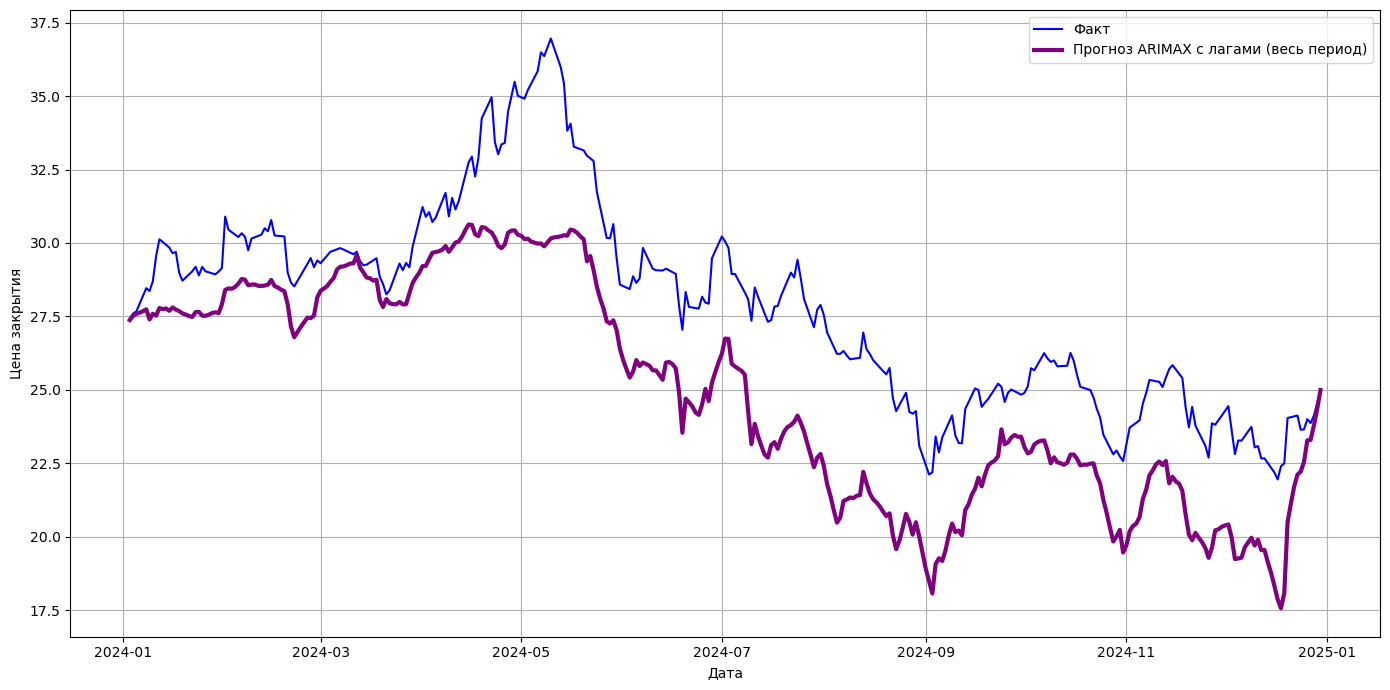

Оптимальные лаги для каждой переменной:
IMOEX Close: 7 лаг(ов)
MOEXOG Close: 7 лаг(ов)
CNY Rate: 10 лаг(ов)
Inflation: 6 лаг(ов)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

# === Загрузка и подготовка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sngs_merged_data_old.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]  # удаление констант

# === Заданный список экзогенов ===
best_features = ["IMOEX Close", "MOEXOG Close", 'CNY Rate', 'Inflation']
best_features = [f for f in best_features if f in df.columns]

# Интерполяция и заполнение пропусков
df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === Поиск оптимальных лагов через тест Грейнджера ===
optimal_lags = {}
target = 'Stock Close'

for feature in best_features:
    try:
        test_result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        optimal_lags[feature] = optimal_lag
    except Exception:
        continue

# === Создание лагов ===
def create_lags(data, lags_dict):
    data_copy = data.copy()
    for feature, lag in lags_dict.items():
        for l in range(1, lag + 1):
            data_copy[f'{feature}_lag{l}'] = data_copy[feature].shift(l)
    return data_copy.dropna()

df_lagged = create_lags(df, optimal_lags)

# === Сплит на train/test ===
split_idx = int(len(df_lagged) * 0.75)
train_lagged = df_lagged.iloc[:split_idx]
test_lagged = df_lagged.iloc[split_idx:]

y_train = train_lagged['Stock Close']
X_train = train_lagged.drop(columns=['Stock Close'])
y_test = test_lagged['Stock Close']
X_test = test_lagged.drop(columns=['Stock Close'])

# === Обучение ARIMAX с лагами ===
optimal_arima = auto_arima(y_train, exogenous=X_train, seasonal=False, d=1,
                           trace=True, stepwise=True, suppress_warnings=True, max_p=3, max_q=3)
print(f"Выбран порядок ARIMA: {optimal_arima.order}")

model = SARIMAX(y_train, exog=X_train, order=optimal_arima.order)
model_fit = model.fit(maxiter=1000, method='powell')

# === Прогноз ===
forecast_arimax_lags = model_fit.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test).fillna(method='ffill')

# === Метрики на всём тестовом периоде ===
mae = mean_absolute_error(y_test, forecast_arimax_lags)
rmse = np.sqrt(mean_squared_error(y_test, forecast_arimax_lags))
mape = np.mean(np.abs((y_test - forecast_arimax_lags) / y_test)) * 100
print(f"Метрики для всего периода - MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%")

# === Метрики для первых 7 дней ===
forecast_7 = forecast_arimax_lags[:7]
dates_7 = y_test.index[:7]
y_test_7 = y_test.loc[dates_7]

mae_7 = mean_absolute_error(y_test_7, forecast_7)
rmse_7 = np.sqrt(mean_squared_error(y_test_7, forecast_7))
mape_7 = np.mean(np.abs((y_test_7 - forecast_7) / y_test_7)) * 100
print(f"Метрики для первых 7 дней - MAE: {mae_7:.3f}, RMSE: {rmse_7:.3f}, MAPE: {mape_7:.2f}%")

# === График 1: весь тестовый период ===
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Факт', color='blue')
plt.plot(y_test.index, forecast_arimax_lags, label='Прогноз ARIMAX с лагами (весь период)', color="purple", linewidth=3)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# === Вывод оптимальных лагов ===
print("Оптимальные лаги для каждой переменной:")
for feature, lag in optimal_lags.items():
    print(f"{feature}: {lag} лаг(ов)")


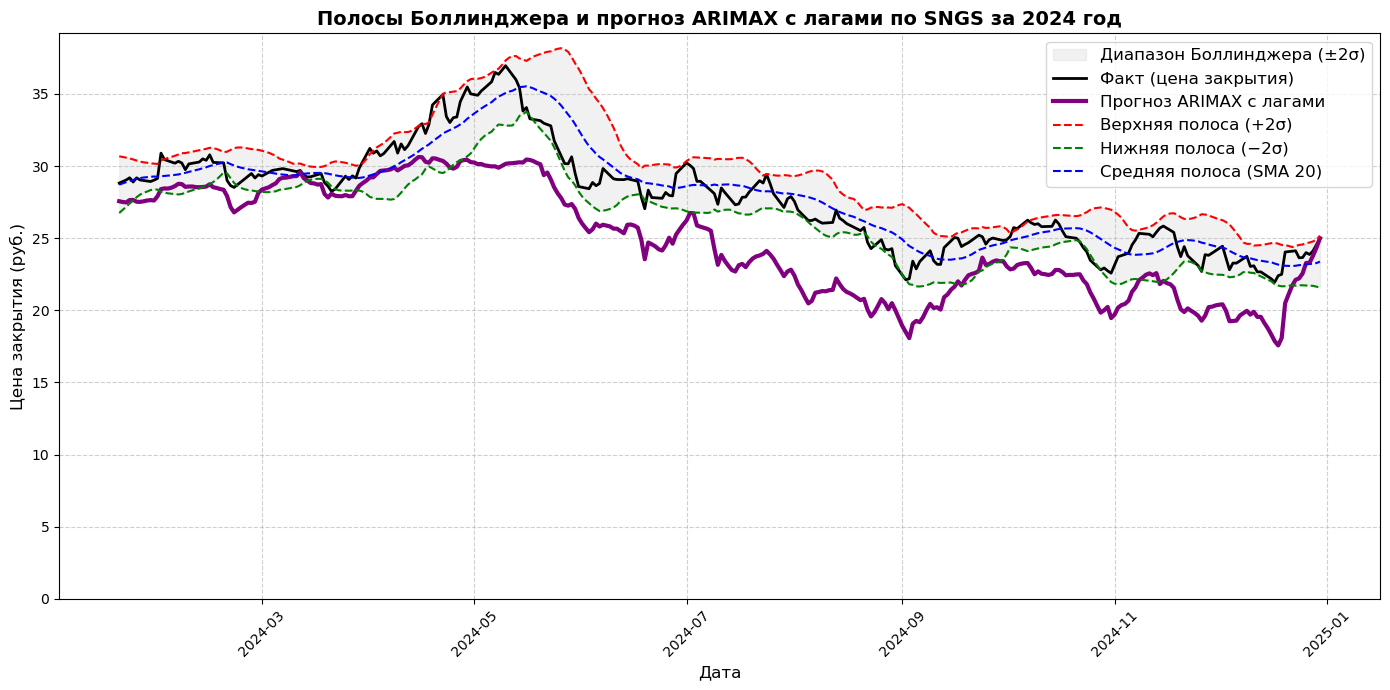

In [28]:
# === Полосы Боллинджера и прогноз ARIMAX с лагами за 2024 год ===

# Подготовка данных за 2024 год
df_boll = df_lagged.loc["2024-01-01":"2024-12-31"].copy()
df_boll["close"] = df_boll["Stock Close"]

# Расчёт полос Боллинджера:
# - Средняя полоса: 20-дневное скользящее среднее
# - Верхняя: средняя + 2σ, Нижняя: средняя − 2σ
df_boll["bollinger_mid"] = df_boll["close"].rolling(window=20).mean()
df_boll["bollinger_std"] = df_boll["close"].rolling(window=20).std()
df_boll["bollinger_upper"] = df_boll["bollinger_mid"] + 2 * df_boll["bollinger_std"]
df_boll["bollinger_lower"] = df_boll["bollinger_mid"] - 2 * df_boll["bollinger_std"]
df_boll.dropna(subset=["bollinger_upper", "bollinger_lower"], inplace=True)

# Получение прогноза ARIMAX в пределах 2024 года
forecast_series = pd.Series(forecast_arimax_lags, index=y_test.index)
forecast_for_boll = forecast_series.loc[df_boll.index.intersection(forecast_series.index)]

# Данные для отображения
actual_for_boll = df_boll["close"].loc[forecast_for_boll.index]
upper = df_boll["bollinger_upper"].loc[forecast_for_boll.index]
lower = df_boll["bollinger_lower"].loc[forecast_for_boll.index]
mid = df_boll["bollinger_mid"].loc[forecast_for_boll.index]

# === Построение графика ===
plt.figure(figsize=(14, 7))

# Заливка между полосами Боллинджера
plt.fill_between(df_boll.index, df_boll["bollinger_lower"], df_boll["bollinger_upper"],
                 color="lightgray", alpha=0.3, label="Диапазон Боллинджера (±2σ)")

# Фактическая цена — жирной чёрной линией
plt.plot(actual_for_boll.index, actual_for_boll, label="Факт (цена закрытия)", color="black", linewidth=2)

# Прогноз ARIMAX — фиолетовая пунктирная линия
plt.plot(forecast_for_boll.index, forecast_for_boll, label="Прогноз ARIMAX с лагами", color="purple", linewidth=3)

# Верхняя, нижняя и средняя полосы Боллинджера
plt.plot(upper.index, upper, label="Верхняя полоса (+2σ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(lower.index, lower, label="Нижняя полоса (−2σ)", color="green", linestyle="--", linewidth=1.5)
plt.plot(mid.index, mid, label="Средняя полоса (SMA 20)", color="blue", linestyle="--", linewidth=1.5)

# Оформление графика
plt.title("Полосы Боллинджера и прогноз ARIMAX с лагами по SNGS за 2024 год", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена закрытия (руб.)", fontsize=12)
plt.ylim(bottom=0)  # ← ВОТ ЭТА СТРОКА — ось Y начинается с 0
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📊 Полосы Боллинджера и прогноз ARIMAX с лагами по акции SNGS (2024)
График объединяет элементы технического анализа (полосы Боллинджера) и статистического моделирования (ARIMAX с лагами), что позволяет визуально оценить рыночную волатильность и качество прогноза модели.

 - Чёрная линия — фактическая цена закрытия акции Stock Close за 2024 год. Используется как база для расчёта индикаторов и верификации прогноза.

- Синяя пунктирная линия — средняя полоса (SMA 20), вычисляемая как скользящее среднее за 20 дней:

SMA(t) = (Pₜ + Pₜ₋₁ + … + Pₜ₋₁₉) / 20

- Красная и зелёная пунктирные линии — границы полос Боллинджера:

Верхняя полоса: Upper(t) = SMA(t) + 2σ(t)
Нижняя полоса: Lower(t) = SMA(t) − 2σ(t)
где σ(t) — стандартное отклонение за последние 20 дней. Эти полосы задают статистический диапазон нормальных рыночных колебаний.

- Фиолетовая пунктирная линия — прогноз ARIMAX с учётом лагов экзогенных переменных. Позволяет оценить, насколько точно модель предсказывает динамику цены.

- Серый полупрозрачный фон — область между верхней и нижней полосами Боллинджера (±2σ), отражающая допустимую рыночную волатильность.

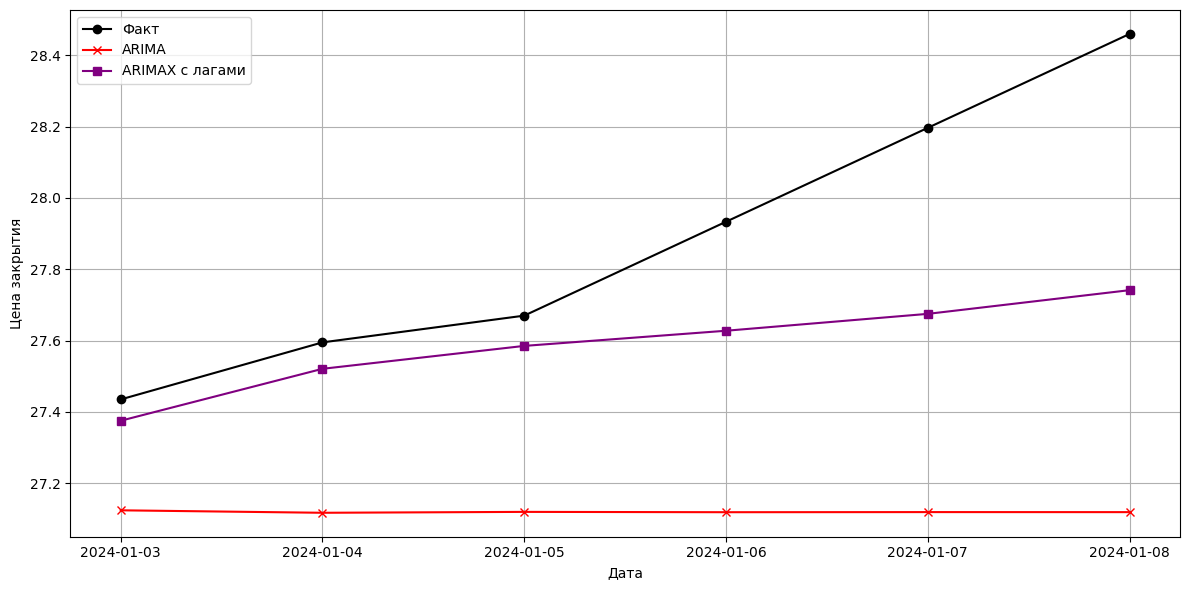

Сравнительная таблица метрик (первые 6 дней прогноза):


,Model,MAE,RMSE,MAPE (%)
0,ARIMA,0.762,0.842,1.946
1,ARIMAX с лагами,0.294,0.387,1.044


In [34]:
# === Сравнительный график: первые 6 дней для ARIMA, ARIMAX (4 экзогена) и ARIMAX с лагами ===

# Получаем прогнозы на первые 6 дней из всех трёх моделей
forecast_arima_6 = forecast_arima[:6]                 # из первой модели (без экзогенов)
forecast_arimax_6 = forecast_arimax_no_lags[:6]       # из второй модели (4 экзогена без лагов)
forecast_arimax_lags_6 = forecast_arimax_lags[:6]     # из третьей модели (с лагами)
dates_6 = y_test.index[:6]
y_test_6 = y_test.loc[dates_6]

# Построение графика
plt.figure(figsize=(12, 6)) 
plt.plot(dates_6, y_test_6, label='Факт', color='black', marker='o')
plt.plot(dates_6, forecast_arima_6, label='ARIMA', color='red', marker='x')
#plt.plot(dates_6, forecast_arimax_6, label='ARIMAX', color='green', marker='^')
plt.plot(dates_6, forecast_arimax_lags_6, label='ARIMAX с лагами', color='purple', marker='s')

#plt.title('Сравнение моделей ARIMA и ARIMAX (первые 6 дней прогноза)')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Сравнительная таблица ошибок на 6-дневном горизонте ===
metrics_table = pd.DataFrame({
    #'Model': ['ARIMA', 'ARIMAX', 'ARIMAX с лагами'],
    'Model': ['ARIMA', 'ARIMAX с лагами'],
    'MAE': [
        mean_absolute_error(y_test_6, forecast_arima_6),
        #mean_absolute_error(y_test_6, forecast_arimax_6),
        mean_absolute_error(y_test_6, forecast_arimax_lags_6)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_6, forecast_arima_6)),
        #np.sqrt(mean_squared_error(y_test_6, forecast_arimax_6)),
        np.sqrt(mean_squared_error(y_test_6, forecast_arimax_lags_6))
    ],
    'MAPE (%)': [
        np.mean(np.abs((y_test_6 - forecast_arima_6) / y_test_6)) * 100,
        #np.mean(np.abs((y_test_6 - forecast_arimax_6) / y_test_6)) * 100,
        np.mean(np.abs((y_test_6 - forecast_arimax_lags_6) / y_test_6)) * 100
    ]
})

print("Сравнительная таблица метрик (первые 6 дней прогноза):")
display(metrics_table.round(3))
